In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif,f_regression

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten, TimeDistributed, Dropout
from keras import optimizers
from sklearn.metrics import mean_squared_error

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
tf.random.set_seed(42)
file_name = '/content/drive/My Drive/Colab Notebooks/extrusion.csv'

df = pd.read_csv(file_name)       
columns = df.columns.tolist()
del df['Datum']
columns.remove('Datum')
df.info()
print(columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226536 entries, 0 to 226535
Columns: 469 entries, ST0_VARActAuftrag to ST114_VARWdTensVis
dtypes: float64(469)
memory usage: 810.6 MB
['ST0_VARActAuftrag', 'ST110_VARExtr_0_HeizungZone_3_Regler_Y', 'ST110_VARExtr_0_HeizungZone_3_SollTemp', 'ST110_VARExtr_0_HeizungZone_4_Konfig', 'ST110_VARExtr_0_HeizungZone_4_Regler_X', 'ST110_VARExtr_0_HeizungZone_4_Regler_Y', 'ST110_VARExtr_0_HeizungZone_4_SollTemp', 'ST110_VARExtr_0_HeizungZone_5_Konfig', 'ST110_VARExtr_0_HeizungZone_5_Regler_X', 'ST110_VARExtr_0_HeizungZone_5_Regler_Y', 'ST110_VARExtr_0_HeizungZone_5_SollTemp', 'ST110_VARExtr_0_HeizungZone_6_Konfig', 'ST110_VARExtr_0_HeizungZone_6_Regler_X', 'ST110_VARExtr_0_HeizungZone_6_Regler_Y', 'ST110_VARExtr_0_HeizungZone_6_SollTemp', 'ST110_VARExtr_0_HeizungZone_7_Konfig', 'ST110_VARExtr_0_HeizungZone_7_Regler_X', 'ST110_VARExtr_0_HeizungZone_7_Regler_Y', 'ST110_VARExtr_0_HeizungZone_7_SollTemp', 'ST110_VARExtr_0_HeizungZone_8_Konfig', 'ST110

In [3]:
target_index = columns.index('ST110_VAREx_0_SDickeIst')
print(target_index)

157


## **코드 순서**
0. Null 데이터 처리
1. PCA 차원 축소
2. SelectKbest 피쳐 셀렉션
3. ACF,CCF (Auto Correlation Function, Cross Correlation Function)

4. 두께 예측 Regression Model
5. 결함 예측 Classification Model
=> 4,5번은 다른 코드 파일에 첨부

# **Null 데이터 처리**

In [4]:
X = np.asarray(df)[:, :]
Y = np.asarray(df)[:, target_index]

print("X.shape: ", X.shape)
print("Y.shape: ", Y.shape)

X.shape:  (226536, 469)
Y.shape:  (226536,)


In [5]:
x = np.array(df)[:200000, :]
print("x.shape: ", x.shape)

y = df['ST110_VAREx_0_SDickeIst']
y = np.array(y)[:200000].reshape(-1, 1)
print("y.shape: ", y.shape)

x.shape:  (200000, 469)
y.shape:  (200000, 1)


In [6]:
print(pd.isnull(x).sum())
print(pd.isnull(y).sum())

125831
58


In [7]:
# null 값이 있는 행을 알아보기 위한 코드
x_isnull= pd.isnull(x)
y_isnull= pd.isnull(y)

null_rowlist =[]
for i in range(len(x_isnull)):
  for j in range(469):
    if x_isnull[i,j] == True:
      null_rowlist.append(i)
      i = i+1
print(null_rowlist)

[18398, 18399, 18400, 18399, 18400, 18400, 18454, 20979, 24019, 24035, 58210, 58211, 58212, 58211, 58212, 58212, 62021, 62022, 62023, 62024, 62025, 62026, 62027, 62028, 62029, 62022, 62023, 62024, 62025, 62026, 62027, 62028, 62029, 62023, 62024, 62025, 62026, 62027, 62028, 62029, 62024, 62025, 62026, 62027, 62028, 62029, 62025, 62026, 62027, 62028, 62029, 62026, 62027, 62028, 62029, 62027, 62028, 62029, 62028, 62029, 62029, 70978, 71524, 71576, 78210, 82932, 82933, 82934, 82933, 82934, 82934, 87052, 87053, 87053, 91158, 96208, 96209, 96210, 96211, 96212, 96213, 96214, 96215, 96216, 96217, 96218, 96219, 96220, 96221, 96222, 96223, 96224, 96225, 96226, 96227, 96228, 96229, 96230, 96231, 96232, 96233, 96234, 96235, 96236, 96237, 96238, 96239, 96240, 96241, 96242, 96243, 96244, 96245, 96246, 96247, 96248, 96249, 96250, 96251, 96252, 96253, 96254, 96255, 96256, 96257, 96258, 96259, 96260, 96261, 96262, 96263, 96264, 96265, 96266, 96267, 96268, 96269, 96270, 96271, 96272, 96273, 96274, 96275

In [8]:
#null이 들어있는 행에 어떤식으로 null 값이 있는지 확인
x_isnull[18400]

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [9]:
for i in range(len(columns)):
    print(i,'->', pd.isnull(x[:, i]).sum())

0 -> 0
1 -> 58
2 -> 58
3 -> 58
4 -> 58
5 -> 58
6 -> 58
7 -> 58
8 -> 58
9 -> 58
10 -> 58
11 -> 58
12 -> 58
13 -> 58
14 -> 58
15 -> 58
16 -> 58
17 -> 58
18 -> 58
19 -> 58
20 -> 58
21 -> 58
22 -> 58
23 -> 58
24 -> 58
25 -> 58
26 -> 58
27 -> 58
28 -> 58
29 -> 58
30 -> 58
31 -> 58
32 -> 58
33 -> 58
34 -> 58
35 -> 58
36 -> 58
37 -> 58
38 -> 58
39 -> 58
40 -> 58
41 -> 58
42 -> 58
43 -> 58
44 -> 58
45 -> 58
46 -> 58
47 -> 58
48 -> 58
49 -> 58
50 -> 58
51 -> 58
52 -> 58
53 -> 58
54 -> 58
55 -> 58
56 -> 58
57 -> 58
58 -> 58
59 -> 58
60 -> 58
61 -> 58
62 -> 58
63 -> 58
64 -> 58
65 -> 58
66 -> 58
67 -> 58
68 -> 58
69 -> 58
70 -> 58
71 -> 58
72 -> 58
73 -> 58
74 -> 58
75 -> 58
76 -> 58
77 -> 58
78 -> 58
79 -> 58
80 -> 58
81 -> 58
82 -> 58
83 -> 58
84 -> 58
85 -> 58
86 -> 58
87 -> 58
88 -> 58
89 -> 58
90 -> 58
91 -> 58
92 -> 58
93 -> 58
94 -> 58
95 -> 58
96 -> 58
97 -> 58
98 -> 58
99 -> 58
100 -> 58
101 -> 58
102 -> 58
103 -> 58
104 -> 58
105 -> 58
106 -> 58
107 -> 58
108 -> 58
109 -> 58
110 -> 58
1

In [10]:
X_all = np.asarray(df)[:, :]
Y_all = np.asarray(df)[:, target_index]

In [11]:
null_row = []

for i in range(len(X_all)):
    for j in range(len(columns)):
        if pd.isnull(X_all[i,j]):
            null_row.append(i)
null_row = sorted(list(set(null_row)))

print(null_row)
print(len(null_row))

[18398, 18399, 18400, 18454, 20979, 24019, 24035, 58210, 58211, 58212, 62021, 62022, 62023, 62024, 62025, 62026, 62027, 62028, 62029, 70978, 71524, 71576, 78210, 82932, 82933, 82934, 87052, 87053, 91158, 96208, 96209, 96210, 96211, 96212, 96213, 96214, 96215, 96216, 96217, 96218, 96219, 96220, 96221, 96222, 96223, 96224, 96225, 96226, 96227, 96228, 96229, 96230, 96231, 96232, 96233, 96234, 96235, 96236, 96237, 96238, 96239, 96240, 96241, 96242, 96243, 96244, 96245, 96246, 96247, 96248, 96249, 96250, 96251, 96252, 96253, 96254, 96255, 96256, 96257, 96258, 96259, 96260, 96261, 96262, 96263, 96264, 96265, 96266, 96267, 96268, 96269, 96270, 96271, 96272, 96273, 96274, 96275, 96276, 96277, 96278, 96279, 96280, 96281, 96282, 96283, 96284, 96285, 96286, 96287, 96288, 96289, 96290, 96291, 96292, 96293, 96294, 96295, 96296, 96297, 96298, 96299, 96300, 96301, 96302, 96303, 96304, 96305, 96306, 96307, 96308, 96309, 96310, 96311, 96312, 96313, 96314, 96315, 96316, 96317, 96318, 96319, 96320, 96321

In [12]:
seq_length = 50
predict_length = 10
input_columns = len(columns)

num_Data = 1

if null_row[0] - 1 > seq_length + predict_length:
    X0 = X_all[:null_row[0] - 1, :]
    Y0 = Y_all[:null_row[0] - 1]

for i in range(1, len(null_row)):
    if null_row[i] - null_row[i-1] - 1 > seq_length + predict_length:
        locals()['X{}'.format(num_Data)] = X_all[null_row[i-1] + 1 : null_row[i] - 1, :]
        locals()['Y{}'.format(num_Data)] = Y_all[null_row[i-1] + 1 : null_row[i] - 1]
        num_Data += 1

for i in range(num_Data):
    print('X{} -> '.format(i), 'The number of null value: ', pd.isnull(locals()['X{}'.format(i)]).sum().sum())
    print('Y{} -> '.format(i), 'The number of null value: ', pd.isnull(locals()['Y{}'.format(i)]).sum().sum())

X0 ->  The number of null value:  0
Y0 ->  The number of null value:  0
X1 ->  The number of null value:  0
Y1 ->  The number of null value:  0
X2 ->  The number of null value:  0
Y2 ->  The number of null value:  0
X3 ->  The number of null value:  0
Y3 ->  The number of null value:  0
X4 ->  The number of null value:  0
Y4 ->  The number of null value:  0
X5 ->  The number of null value:  0
Y5 ->  The number of null value:  0
X6 ->  The number of null value:  0
Y6 ->  The number of null value:  0
X7 ->  The number of null value:  0
Y7 ->  The number of null value:  0
X8 ->  The number of null value:  0
Y8 ->  The number of null value:  0
X9 ->  The number of null value:  0
Y9 ->  The number of null value:  0
X10 ->  The number of null value:  0
Y10 ->  The number of null value:  0
X11 ->  The number of null value:  0
Y11 ->  The number of null value:  0
X12 ->  The number of null value:  0
Y12 ->  The number of null value:  0
X13 ->  The number of null value:  0
Y13 ->  The number of

In [13]:
for i in range(num_Data):
    print('Y{}.shape = '.format(i), locals()['Y{}'.format(i)].shape)

Y0.shape =  (18397,)
Y1.shape =  (2523,)
Y2.shape =  (3038,)
Y3.shape =  (34173,)
Y4.shape =  (3807,)
Y5.shape =  (8947,)
Y6.shape =  (544,)
Y7.shape =  (6632,)
Y8.shape =  (4720,)
Y9.shape =  (4116,)
Y10.shape =  (4103,)
Y11.shape =  (5048,)
Y12.shape =  (24594,)
Y13.shape =  (416,)
Y14.shape =  (3948,)
Y15.shape =  (8201,)
Y16.shape =  (2915,)
Y17.shape =  (2347,)
Y18.shape =  (69,)
Y19.shape =  (7396,)
Y20.shape =  (3704,)
Y21.shape =  (2903,)
Y22.shape =  (4020,)
Y23.shape =  (9176,)
Y24.shape =  (11618,)
Y25.shape =  (7931,)
Y26.shape =  (3909,)
Y27.shape =  (13658,)
Y28.shape =  (5338,)


# **PCA차원축소**

In [14]:
# corr_matrix = df.corr()
# corr_matrix  #먼저 nan값 제거가 필요함.

In [15]:
## 1.PCA 차원 축소 ## 
#NAN 제거가 우선 되어야 한다.
#우선 10000까지는 nan 값이 없으므로
#결측치 제거 전에 10000이전의 데이터 들로 먼저 연습삼아 PCA를 해본다.

x = np.array(df)[:10000, :]
print("x.shape: ", x.shape)

y = df['ST110_VAREx_0_SDickeIst']
y = np.array(y)[:10000].reshape(-1, 1)
print("y.shape: ", y.shape)

x.shape:  (10000, 469)
y.shape:  (10000, 1)


In [16]:
print(pd.isnull(x).sum())
print(pd.isnull(y).sum())

0
0


In [17]:
trainX, testX, trainY, testY = train_test_split(x, y, test_size=0.3, shuffle = False)

scaler = MinMaxScaler()
trainX = scaler.fit_transform(trainX)
trainY = scaler.fit_transform(trainY)
testX = scaler.transform(testX)
testY = scaler.transform(testY)

print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(7000, 469)
(7000, 1)
(3000, 469)
(3000, 1)


In [18]:
pca = PCA()
pca.fit(trainX)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.9)+1
print('Reduced dimension %d (train data)' % d)

pca = PCA(n_components = d)
trainX_reduced = pca.fit_transform(trainX)
testX_reduced = pca.transform(testX)

Reduced dimension 10 (train data)


In [19]:
print(trainX_reduced.shape)
print(testX_reduced.shape)
print(trainY.shape)
print(testY.shape)

(7000, 10)
(3000, 10)
(7000, 1)
(3000, 1)


In [20]:
print(pca.explained_variance_ratio_)
pca.explained_variance_ratio_.sum()

#새로 추출된 10개의 피쳐가 90퍼센트를 반영한다.

[0.4562312  0.13263087 0.0962566  0.08341134 0.0513946  0.02966051
 0.01988823 0.01470055 0.01202064 0.01077603]


0.9069705809420721

In [21]:
#PCA #2
#PCA 하고 SCALE
pca = PCA(n_components=8)

#fit( )과 transform( ) 을 호출하여 PCA 변환 데이터 반환
x_pca = pca.fit_transform(x)

print(x_pca.shape)

#MinMaxScale

x_scaled = MinMaxScaler().fit_transform(x_pca)
y_scaled = MinMaxScaler().fit_transform(y)

pca_columns=['pca_component_1','pca_component_2','pca_component_3','pca_component_4','pca_component_5','pca_component_6','pca_component_7','pca_component_8']
df_pca = pd.DataFrame(x_scaled, columns=pca_columns)
# df_pca.head(5)
print(df_pca)

(10000, 8)
      pca_component_1  pca_component_2  ...  pca_component_7  pca_component_8
0        0.000000e+00         0.879272  ...         0.129214         0.549308
1        4.509692e-07         0.878304  ...         0.131870         0.550246
2        9.147265e-07         0.877332  ...         0.135346         0.552022
3        1.367220e-06         0.876361  ...         0.138276         0.553144
4        1.817634e-06         0.875394  ...         0.141477         0.554519
...               ...              ...  ...              ...              ...
9995     9.990696e-01         0.467148  ...         0.131382         0.484166
9996     9.990700e-01         0.466158  ...         0.134429         0.485415
9997     9.990705e-01         0.465164  ...         0.137361         0.486901
9998     9.990710e-01         0.464156  ...         0.139262         0.486747
9999     1.000000e+00         0.469990  ...         0.127138         0.482316

[10000 rows x 8 columns]


In [22]:
print(pca.explained_variance_ratio_)
pca.explained_variance_ratio_.sum()

#PCA를 8개 요소로 변환해도 원본 데이터의 변동성을 약 99% 설명할 수 있다 (정보 손실이 거의 0퍼센트) 

[9.99701113e-01 1.96901348e-04 7.87812374e-05 1.06354441e-05
 6.03562036e-06 2.24404331e-06 1.27220376e-06 1.14312647e-06]


0.9999981257459621

# **SelectKbest 피쳐셀렉션**

In [23]:
# feature extraction
k = 11
test = SelectKBest(score_func = f_classif, k = k)
fit = test.fit(x, y)

#print(fit.scores_)

#summarize scores
np.set_printoptions(precision=1)
#print(fit.scores_)
features = fit.transform(x)
#print(features[0:5,:])
features.shape

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  0   3   7  11  13  14  15  17  18  19  21  22  23  25  26  29  34  39
  44  48  49  51  52  53  54  55  56  57  59  64  71  76  81  86  91  95
  96  97  98  99 101 106 113 118 123 128 132 133 135 136 137 138 139 140
 141 143 148 158 164 167 169 170 171 174 175 177 179 181 187 189 191 197
 199 201 204 205 206 217 220 222 224 230 232 234 240 242 244 250 252 254
 259 270 273 275 276 277 280 281 283 285 287 293 295 297 303 305 307 312
 323 330 333 334 335 336 337 338 339 358 368 369 377 380 381 382 385 387
 388 389 390 391 392 396 398 400 410 411 414 415 420 422 423 428 431 432
 433 436 439 440 441 442 443 454 455 4

(10000, 11)

In [26]:
X_10000 = np.asarray(df)[:10000, :]
Y_10000 = np.asarray(df)[:10000, target_index]

In [44]:
# feature extraction
k = 11
test = SelectKBest(score_func = f_regression, k = k)
#test = SelectKBest(score_func = f_classif, k = k)
fit = test.fit(X_10000, Y_10000)

# summarize scores
# np.set_printoptions(precision=3)
# print(fit.scores_)
features = fit.transform(X_10000)
#print(features[0:5,:])#[0:5,:]


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:293: RuntimeWarning: invalid value encountered in sqrt
  n_samples * X_means ** 2)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


In [50]:
mask = test.get_support() #list of booleans
new_features = [] # The list of your K best features

for bool, feature in zip(mask, columns):
    if bool:
        new_features.append(feature)

print(new_features)

['ST110_VAREx_0_Dos_0_IstLMGewicht', 'ST110_VAREx_0_SDickeIst', 'ST110_VAREx_1_Dos_0_IstLMGewicht', 'ST110_VAREx_1_SDickeIst', 'ST110_VAREx_2_Dos_0_IstLMGewicht', 'ST110_VAREx_2_SDickeIst', 'ST110_VAREx_3_Dos_0_IstLMGewicht', 'ST110_VAREx_3_Dos_3_IstDurchsatz', 'ST110_VAREx_3_Dos_3_SollStatus', 'ST110_VAREx_3_SDickeIst', 'ST110_VARTrichter_16_Vorwahl']


In [ ]:
seq_length = 30
predict_length = 2
input_columns = k

In [ ]:
dataX = []
dataY = []
for i in range(0, len(y) - seq_length - predict_length + 1):
    _x = x[i : i + seq_length]
    #_y = y[i + predict_length : i + seq_length + predict_length]
    _y = y[i + seq_length : i + seq_length + predict_length]
    
    dataX.append(_x)
    dataY.append(_y)

# dataY = np.concatenate(dataY, axis=0)

dataX = np.array(dataX)
dataY = np.array(dataY)

print(dataX.shape)
print(dataY.shape) # 2차원[][] -> [,] 바꿔야함 #(9969,2)

In [ ]:
trainX, testX, trainY, testY = train_test_split(dataX, dataY, test_size=0.3, shuffle = False)
trainY = tf.expand_dims(trainY,2)
testY = tf.expand_dims(testY,2)

print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

In [ ]:
# LSTM 모델 / LSTM Model
model = Sequential([
    LSTM(32, input_shape = (seq_length, input_columns), return_sequences=True, activation = 'relu'),
    LSTM(16, return_sequences=False, activation = 'relu'),
    Dense(2)
])
model.summary()

In [ ]:
# 모델 학습 설정 및 진행 / Model Training options and Progress
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='loss', patience=5)

adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(loss='mse', optimizer = adam, metrics=["mse"])
history = model.fit(trainX, trainY, batch_size = 100, epochs=5, validation_split=0.1, callbacks=[early_stopping])

In [ ]:
# 학습 과정 살펴보기 / watching train loss
print(history.history['loss'])
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()
loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')
plt.show()

In [ ]:
model.evaluate(testX, testY)
# 예측
pred = model.predict(testX)
plt.figure(figsize=(12, 9))
plt.plot(testY[:,1], label='actual')
plt.plot(np.mean(pred, axis = 1), label='prediction')
plt.legend()
# plt.xlim(3400,5000)
# plt.ylim(-2, 3)
plt.show()

# **ACF(Auto Correlation Function)**

In [38]:
def crosscorr(datax, datay, lag=0):
    """ Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    return datax.corr(datay.shift(lag))

def autocorr(self, lag=1):
    """
    Lag-N autocorrelation

    Parameters
    ----------
    lag : int, default 1
        Number of lags to apply before performing autocorrelation.

    Returns
    -------
    autocorr : float
    """
    return self.corr(self.shift(lag))

In [39]:
Y_ = df.iloc[:18000, 157]

In [40]:
def standardScaler(X):
    return (X - np.mean(X, axis = 0)) / np.std(X, ddof = 1, axis = 0)

def minmaxScaler(x):
    x_np = np.asarray(x)

    return (x_np - x_np.min(axis=0)) / (x_np.max(axis=0) - x_np.min(axis=0)+ 1e-7) # 1e-7은 0으로 나누는 오류 예방차원
y = minmaxScaler(Y_)
print(y.shape)

(18000,)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


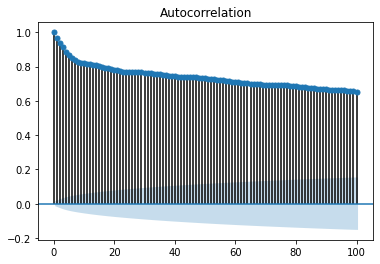

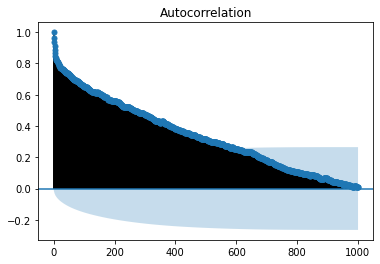

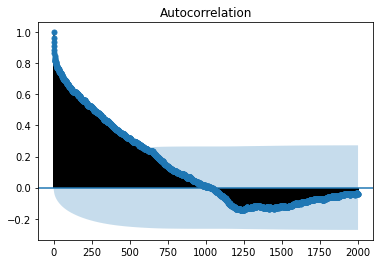

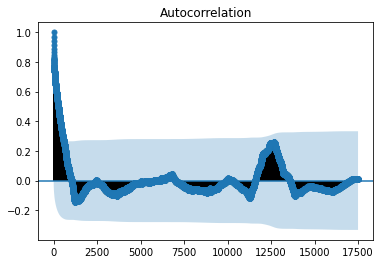

In [41]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(y,lags = 100)
plt.show()
plot_acf(y,lags = 2000)
plt.show()
plot_acf(y,lags = 17500)
plt.show()

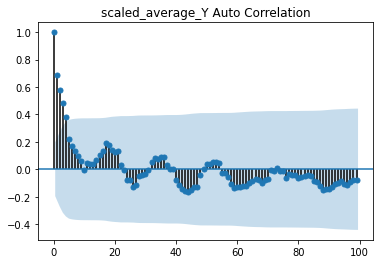

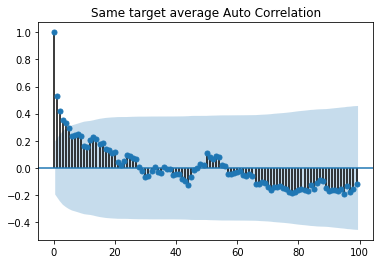

In [61]:
# Auto Correlation

from statsmodels.graphics.tsaplots import plot_acf

def min_max_scaling(x):
    x_np = np.asarray(x)
    return (x_np - x_np.min()) / (x_np.max() - x_np.min())

mini_batch_size = 100

for i in range(len(Y0)//mini_batch_size):
    locals()['scaledY{}'.format(i)] = min_max_scaling(Y0[i*mini_batch_size : i*mini_batch_size + mini_batch_size]) - np.mean(min_max_scaling(Y0[i*mini_batch_size : i*mini_batch_size + mini_batch_size]))
    locals()['RMSE{}'.format(i)] = np.sqrt(np.mean((locals()['scaledY{}'.format(i)])**2))
    locals()['RMSEscaledY{}'.format(i)] = locals()['scaledY{}'.format(i)] / locals()['RMSE{}'.format(i)]

# from statsmodels.graphics.tsaplots import plot_acf

# for j in range(i):
#     plot_acf(locals()['RMSEscaledY{}'.format(j)], lags = 99, title = 'scaledY{} Auto Correlation'.format(j))

RMSEscaled = []

for j in range(i):
  RMSEscaled.append(locals()['RMSEscaledY{}'.format(j)])
  
a = sum(RMSEscaled)/i

plot_acf(a, lags = mini_batch_size-1, title = 'scaled_average_Y Auto Correlation')
plt.show()

##########################################################################

j = 0
ary = []
count_time_index = []

target_values = df['ST110_VAREx_0_SDickeIst'][0:18397].values
Control_values = df['ST110_VAREx_0_SDickeSoll'][0:18397].values
Control_values = list(Control_values)

for i in range(len(Control_values) - 1):
    if float(Control_values[i+1] - Control_values[i]) == 0.0:
        ary.append(target_values[i])
        count_time_index.append(i)
    else:
        locals()['target{}'.format(j)] = ary
        count_time_index.append(i)
        locals()['time_index{}'.format(j)] = count_time_index
        ary = []
        count_time_index=[]
        j += 1
        ary.append(target_values[i])
        #count_time_index.append(i)

Large_than_100 = []

for i in range(j):
    if len(locals()['target{}'.format(i)]) > mini_batch_size: 
        Large_than_100.append(i)

loop_cnt = 1

for i in Large_than_100:
    for k in range(len(locals()['target{}'.format(i)]) // mini_batch_size):
        locals()['len100_target{}'.format(i)] = min_max_scaling(locals()['target{}'.format(i)][k*mini_batch_size : k*mini_batch_size + mini_batch_size]) - np.mean(min_max_scaling(locals()['target{}'.format(i)][k*mini_batch_size : k*mini_batch_size + mini_batch_size]))
        locals()['RMS{}'.format(i)] = np.sqrt(np.mean((locals()['len100_target{}'.format(i)])**2))
        locals()['RMSscaled{}'.format(i)] = locals()['len100_target{}'.format(i)] / locals()['RMS{}'.format(i)]
        loop_cnt += 1

RMSEscaled_same = []

for i in Large_than_100:
    RMSEscaled_same.append(locals()['RMSscaled{}'.format(i)])
  
avg = sum(RMSEscaled_same) / loop_cnt


plot_acf(avg, lags = mini_batch_size-1, title = 'Same target average Auto Correlation')
plt.show()

# **Cross Correlation Function(CCF) 및 피쳐 선택**

In [62]:
from statsmodels.tsa.stattools import ccf

#cross correlation array 

crscor = []
delayed_columns = []
index_cor_max = []

for a in range(len(Large_than_100)):
  delayed_columns = []
  index_cor_max = []
  crscor = [] 
  for i in range(len(columns)):
     startpoint=locals()['time_index{}'.format(Large_than_100[a])][0]
     endpoint =locals()['time_index{}'.format(Large_than_100[a])][-1]
     locals()['tmp{}'.format(a)] = ccf(X0[startpoint:endpoint,i], Y0[startpoint:endpoint], unbiased = False)
    
     crscor.append(locals()['tmp{}'.format(a)])
     locals()['crscor{}'.format(a)] = crscor
     
     if (np.abs(locals()['tmp{}'.format(a)][0]) < np.abs(locals()['tmp{}'.format(a)][1:])).any():
        delayed_columns.append(i)
        locals()['delayed_columns{}'.format(a)] = delayed_columns
        abs_cor_max = np.max(np.abs(locals()['tmp{}'.format(a)]))
        ary2lst = np.abs(locals()['tmp{}'.format(a)]).tolist()
        find_index = ary2lst.index(abs_cor_max)
        index_cor_max.append(find_index)
        locals()['index_cor_max{}'.format(a)] = index_cor_max
     

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:885: RuntimeWarning: invalid value encountered in true_divide
  return cvf / (np.std(x) * np.std(y))


In [63]:
Correlation07 = []
find_maxj = []
for a in range(len(Large_than_100)):
  Correlation07 = []
  find_maxj = []
  print("Cross_correlation_{}".format(Large_than_100[a]))

  for i, j in zip(locals()['delayed_columns{}'.format(a)], locals()['index_cor_max{}'.format(a)]):
      if np.abs(locals()['crscor{}'.format(a)][i][j]) > 0.7:
          print('idex = ({},{})'.format(i,j), '   correlation = ', locals()['crscor{}'.format(a)][i][j])
          Correlation07.append(i)
          locals()['Correlation07_{}'.format(a)]=Correlation07
          find_maxj.append(j)
          locals()['find_maxj_{}'.format(a)]=find_maxj
  print("="*100)
  print("="*100)

Cross_correlation_0
idex = (30,1)    correlation =  -0.7784353924589699
idex = (45,1)    correlation =  0.8349175877520583
idex = (60,1)    correlation =  0.8681956075742762
idex = (65,1)    correlation =  -0.8681956075742762
idex = (87,1)    correlation =  -0.821252185092055
idex = (90,1)    correlation =  -0.8456389023192726
idex = (102,1)    correlation =  0.8681956075742762
idex = (114,1)    correlation =  -0.8154204347919994
idex = (144,1)    correlation =  0.8681956075742762
idex = (149,1)    correlation =  -0.8681956075742762
idex = (160,2)    correlation =  0.7069611549305636
idex = (364,1)    correlation =  0.8681956075742723
idex = (384,1)    correlation =  0.8681956075742723
idex = (435,1)    correlation =  0.8681956075742723
Cross_correlation_5
Cross_correlation_7
idex = (8,2)    correlation =  0.7960454348755229
idex = (35,1)    correlation =  -0.8328193976101528
idex = (38,3)    correlation =  0.704054267482001
idex = (40,2)    correlation =  -0.8654722507021259
idex = (4

In [66]:
from statsmodels.tsa.stattools import ccf

#cross correlation array 

crscor = []
delayed_columns = []
index_cor_max = []
inv_crscor = []
inv_delayed_columns = []
inv_index_cor_max = []

for i in range(len(columns)):
    tmp1 = ccf(X0[:,i], Y0, unbiased = False)
    tmp2 = ccf(Y0, X0[:,i], unbiased = False)
    crscor.append(tmp1) 
    inv_crscor.append(tmp2)

    if (np.abs(tmp1[0]) < np.abs(tmp1[1:])).any():
        delayed_columns.append(i)
            
        abs_cor_max = np.max(np.abs(tmp1))
        ary2lst = np.abs(tmp1).tolist()
        find_index = ary2lst.index(abs_cor_max)
        index_cor_max.append(find_index)

    if (np.abs(tmp2[0]) < np.abs(tmp2[1:])).any():
        inv_delayed_columns.append(i)
            
        inv_abs_cor_max = np.max(np.abs(tmp2))
        inv_ary2lst = np.abs(tmp2).tolist()
        inv_find_index = ary2lst.index(abs_cor_max)
        inv_index_cor_max.append(find_index)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:885: RuntimeWarning: invalid value encountered in true_divide
  return cvf / (np.std(x) * np.std(y))


idex = (30,1)    correlation =  -0.634405265566706
idex = (32,4)    correlation =  -0.625088321913212
idex = (35,2)    correlation =  -0.6379626707577091
idex = (36,45)    correlation =  -0.6456600325638123
idex = (37,4)    correlation =  -0.6318496326448898
idex = (40,4)    correlation =  -0.6349966101721922
idex = (45,9)    correlation =  -0.6253716581869566
idex = (46,3)    correlation =  -0.6455356607279191
idex = (60,8)    correlation =  -0.6212306915038437
idex = (78,5)    correlation =  -0.759407438014255
idex = (83,5)    correlation =  -0.7907396221474948
idex = (88,5)    correlation =  -0.7068090735501236
idex = (114,1)    correlation =  -0.6431468624218741
idex = (119,2)    correlation =  -0.6511375148612475
idex = (124,6)    correlation =  -0.6811858344895039
idex = (130,3)    correlation =  -0.7345577676373062
idex = (144,9)    correlation =  -0.6423581147050393
idex = (159,29)    correlation =  0.797835835657363
idex = (166,28)    correlation =  0.6858163261041378
idex = (

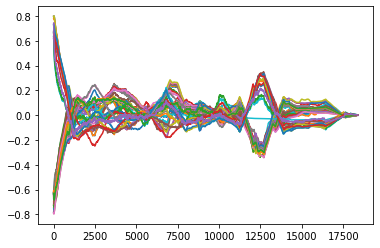

idex = (30,-1)    correlation =  -0.6294640060292669
idex = (32,-4)    correlation =  -0.6250335917265698
idex = (35,-2)    correlation =  -0.6306222110171844
idex = (36,-45)    correlation =  -0.6481494460163263
idex = (37,-4)    correlation =  -0.63202293675172
idex = (40,-4)    correlation =  -0.6283542386644754
idex = (42,-49)    correlation =  -0.6454163315972938
idex = (45,-9)    correlation =  -0.6217267498029837
idex = (47,-3)    correlation =  -0.6250190681605371
idex = (60,-8)    correlation =  -0.617938992348685
idex = (62,-1)    correlation =  -0.6168184222150815
idex = (65,-5)    correlation =  -0.6132372507034034
idex = (67,-5)    correlation =  -0.6097739207977932
idex = (114,-1)    correlation =  -0.6396640627476953
idex = (116,-22)    correlation =  -0.6394546008817756
idex = (119,-2)    correlation =  -0.646546903505814
idex = (121,-48)    correlation =  -0.665634765660373
idex = (124,-6)    correlation =  -0.6792487084757394
idex = (126,-51)    correlation =  -0.6964

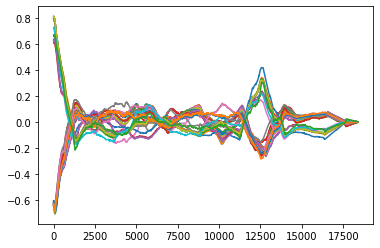

In [67]:
Correlation_index = []
find_maxj = []
Correlation_result = []
for i, j in zip(delayed_columns, index_cor_max):
    if np.abs(crscor[i][j]) > 0.6:
        print('idex = ({},{})'.format(i,j), '   correlation = ', crscor[i][j])
        Correlation_result.append(crscor[i][j])
        Correlation_index.append(i)
        find_maxj.append(j)
        plt.plot(crscor[i])
plt.show()
print('='*50)

inv_Correlation_index = []
inv_find_maxj = []
inv_Correlation_result = []

for i, j in zip(inv_delayed_columns, inv_index_cor_max):
    if np.abs(inv_crscor[i][j]) > 0.6:
        print('idex = ({},{})'.format(i,-1*j), '   correlation = ', inv_crscor[i][j])
        inv_Correlation_result.append(crscor[i][j])
        inv_Correlation_index.append(i)
        inv_find_maxj.append(j)
        plt.plot(inv_crscor[i])
plt.show()

In [68]:
np.asarray(columns)[Correlation_index]

array(['ST110_VARExtr_1_HeizungZone_1_Regler_X',
       'ST110_VARExtr_1_HeizungZone_1_SollTemp',
       'ST110_VARExtr_1_HeizungZone_2_Regler_X',
       'ST110_VARExtr_1_HeizungZone_2_Regler_Y',
       'ST110_VARExtr_1_HeizungZone_2_SollTemp',
       'ST110_VARExtr_1_HeizungZone_3_Regler_X',
       'ST110_VARExtr_1_HeizungZone_4_Regler_X',
       'ST110_VARExtr_1_HeizungZone_4_Regler_Y',
       'ST110_VARExtr_1_HeizungZone_7_Regler_X',
       'ST110_VARExtr_2_HeizungZone_2_Regler_Y',
       'ST110_VARExtr_2_HeizungZone_3_Regler_Y',
       'ST110_VARExtr_2_HeizungZone_4_Regler_Y',
       'ST110_VARExtr_3_HeizungZone_1_Regler_X',
       'ST110_VARExtr_3_HeizungZone_2_Regler_X',
       'ST110_VARExtr_3_HeizungZone_3_Regler_X',
       'ST110_VARExtr_3_HeizungZone_4_Regler_Y',
       'ST110_VARExtr_3_HeizungZone_7_Regler_X',
       'ST110_VAREx_0_SDickeSoll', 'ST110_VAREx_1_Dos_2_IstAnteil',
       'ST110_VAREx_1_Dos_2_IstDurchsatz',
       'ST110_VAREx_1_Dos_2_SollAnteil', 'ST110_VAREx_1_

In [69]:
Correlation_index = sorted(set(Correlation_index + inv_Correlation_index))
print(Correlation_index)

[30, 32, 35, 36, 37, 40, 42, 45, 46, 47, 60, 62, 65, 67, 78, 83, 88, 114, 116, 119, 121, 124, 126, 130, 131, 144, 146, 149, 151, 159, 161, 166, 168, 172, 184, 185, 186, 192, 194, 195, 213, 214, 235, 253, 261, 266, 267, 272, 274, 278, 282, 288, 292, 298, 319, 320, 331, 332, 347, 351, 465, 468]


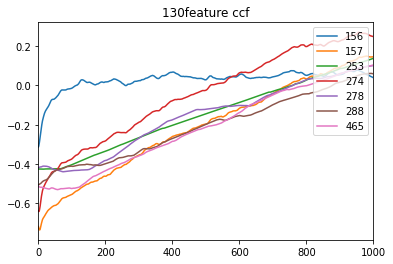

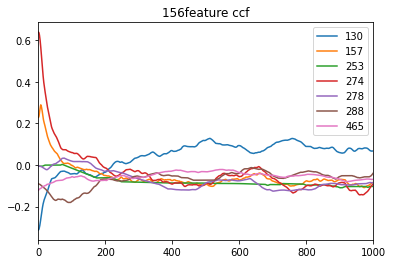

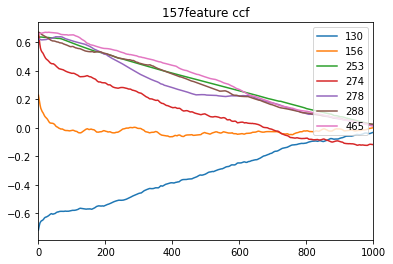

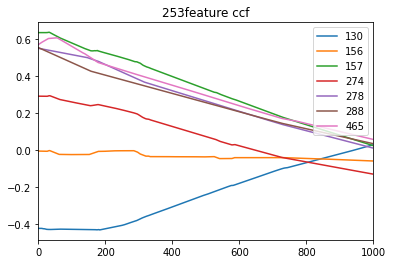

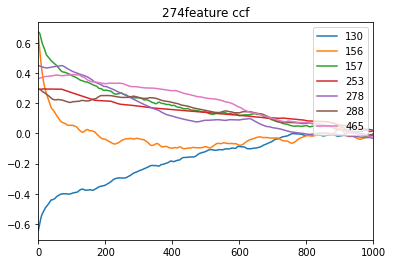

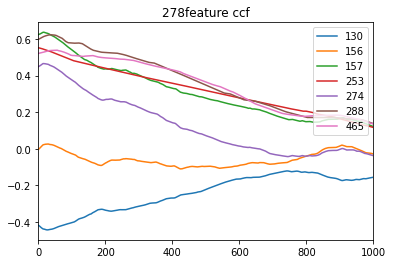

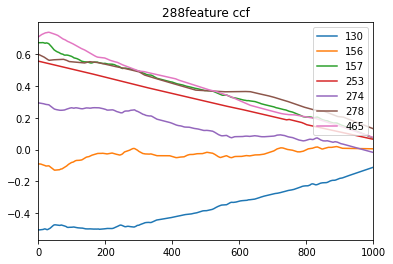

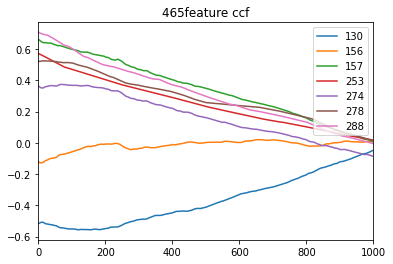

In [70]:
selected_feature_idx = [130, 156, 157, 253, 274, 278, 288, 465]
# selected_feature_idx = [36, 46, 130, 156, 157, 159, 253, 261, 274, 278, 288, 465, 468]
# selected_feature_idx = [111, 364, 435]
for i in selected_feature_idx:
    for j in selected_feature_idx:
        if i != j:
            plt.plot(ccf(X0[:,i], X0[:,j], unbiased = False), label='{}'.format(j))
            plt.title('{}feature ccf'.format(i))
            plt.legend(loc = 1)
    plt.xlim(0, 1000)
    plt.show()